In [20]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix
import mplhep as hep

In [2]:
class GraphNet(nn.Module):
    def __init__(self, input_dim = 8, hidden_dim = 64, output_dim = 1, aggr = 'add', niters = 2):
        super(GraphNet, self).__init__()
        
        # transform to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh()
        )
        
        # to compute messages
        convnetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        
        # edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.niters = niters
    
    def forward(self, data):
        X = data.x
        #print(f"edges {data.num_edges}")
        #print(f"initial X size {X.size()}")
        H = self.inputnetwork(X)
        #print(f"size after inputnet {H.size()}")
        for i in range(self.niters):
            H = self.graphconv(H, data.edge_index)
            #print(f"size of H after {i}th iter {H.size()}")
            
        src, dst = data.edge_index
        #print(f"src size {H[src].size()} dest size {H[dst].size()}")
        #print(f"torch cat {torch.cat([H[src], H[dst]], dim=-1).size()}")
        #print(f"GraphNet returns {self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1).size()}")
        #print(f"score size {(H[src] * H[dst]).sum(dim=-1)}")
        #return (H[src] * H[dst]).sum(dim=-1)
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [3]:
# Load data
with open("node_features", "rb") as fp:
    X = pickle.load(fp)
    
with open("edges", "rb") as fp:
    Edges = pickle.load(fp)
    
with open("edges_labels", "rb") as fp:
    Edge_labels = pickle.load(fp)

In [4]:
# process data
edge_data = []
edge_label = []
node_data = []
for ev in range(len(X)):
    if len(Edges[ev]) == 0:
        print(f"event {ev} edges {Edges[ev]}")
        continue # skip events with no edges
    else:
        X_ev = []
        edge_data.append(Edges[ev])
        edge_label.append([np.float32(edg) for edg in Edge_labels[ev]])
        for field in X[ev].fields:
            X_ev.append(ak.to_numpy(X[ev][field]))
        node_data.append(X_ev)

event 151 edges []


In [5]:
data_list = []
for ev in range(len(node_data)):
    x = torch.from_numpy(np.array(node_data[ev]).T)
    e_label = torch.from_numpy(np.array(edge_label[ev]))
    edge_index = torch.from_numpy(edge_data[ev])
    data = Data(x=x, num_nodes=torch.tensor(x.shape[0]), edge_index=edge_index, edge_label=e_label)
    data_list.append(data)

In [6]:
# split into train, val, test sets

trainRatio = 0.8
valRatio = 0.1
testRatio = 0.1

nSamples = len(data_list)

nTrain = int( trainRatio * nSamples  )
nVal = int( valRatio * nSamples )

trainDataset = data_list[:nTrain]           # training dataset
valDataset = data_list[nTrain:nTrain+nVal]  # validation dataset
testDataset = data_list[nTrain+nVal:]       # test dataset

In [10]:
len(testDataset)

501

In [17]:
# Training

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNet().to(device)
#data = data_list.to(device)
trainLoader = DataLoader(trainDataset, batch_size=32)
valLoader = DataLoader(valDataset, batch_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

train_loss_history = []
val_loss_history = []
model.train()
for epoch in range(20):
    batchloss = []
    for sample in trainLoader:
        optimizer.zero_grad()
        sample.to(device)
        out = model(sample)
        loss = F.binary_cross_entropy(out, sample.edge_label)
        batchloss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    train_loss_history.append(np.mean(batchloss))

    with torch.set_grad_enabled( False ):
        batchloss = []
        for sample in valLoader:
            out = model(sample)
            val_loss = F.binary_cross_entropy(out, sample.edge_label)
            batchloss.append(val_loss.item())
            
    val_loss_history.append(np.mean(batchloss))
    print(f"epoch {epoch} - train loss {train_loss_history[-1]} - val loss {val_loss_history[-1]}")

epoch 0 - train loss 0.731588180065155 - val loss 0.5781312920153141
epoch 1 - train loss 0.5458562631607056 - val loss 0.5414510611444712
epoch 2 - train loss 0.5261508481502533 - val loss 0.5258158687502146
epoch 3 - train loss 0.514261709690094 - val loss 0.5201858691871166
epoch 4 - train loss 0.5075205550193786 - val loss 0.5150054935365915
epoch 5 - train loss 0.5023040878772735 - val loss 0.5101270582526922
epoch 6 - train loss 0.49872483134269713 - val loss 0.508313488215208
epoch 7 - train loss 0.49529837107658387 - val loss 0.5061880890280008
epoch 8 - train loss 0.4926343777179718 - val loss 0.5050541218370199
epoch 9 - train loss 0.4910788779258728 - val loss 0.5041733309626579
epoch 10 - train loss 0.4889826047420502 - val loss 0.5011542961001396
epoch 11 - train loss 0.4863084065914154 - val loss 0.5002899803221226
epoch 12 - train loss 0.4849181125164032 - val loss 0.4976485073566437
epoch 13 - train loss 0.4829326231479645 - val loss 0.49792055413126945
epoch 14 - train

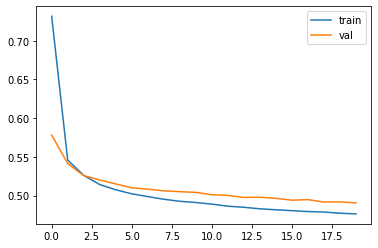

In [18]:
plt.plot(range(20), train_loss_history, label='train')
plt.plot(range(20), val_loss_history, label='val')
plt.legend()

In [24]:
def getAccuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.size(0)

trainLoader = DataLoader(trainDataset, batch_size=len(testDataset))

for sample in trainLoader:
    out = model(sample)
    acc = getAccuracy(sample.edge_label, out)
    y_test = out > 0.5
    cf_matrix = confusion_matrix(sample.edge_label.detach().numpy(), y_test.detach().numpy())
print(f"Accuracy in test data {acc*100} %")
print(f"Confusion matrix {cf_matrix}")

Accuracy in test data 79.38115179016252 %
[[  3599  26996]
 [  3630 114309]]


TN: 3599, FP: 26996, FN: 3630, TP: 114309


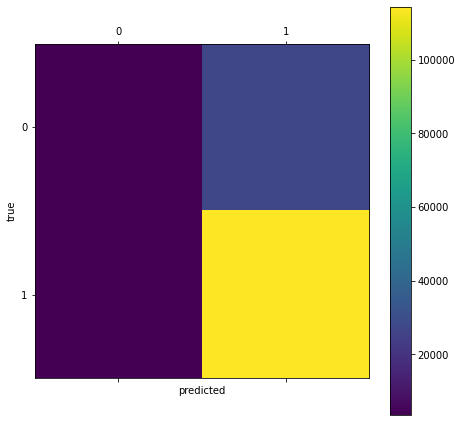

In [38]:
tn, fp, fn, tp = cf_matrix.ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.set_xlabel("predicted")
px.set_ylabel("true")
cax = px.matshow(cf_matrix)
fig.colorbar(cax)